<a href="https://colab.research.google.com/github/aburchell/pollack-notebooks/blob/main/fixedNoiseAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro and Setup
Here we will be analyzing the data that is like the Pollack task but uses sliders - we want to see if there is any "memory" or "recall" effect on how participants make tone judgements.

In [ ]:
# import in all nessecary modules 
import json
from collections import namedtuple 
import numpy as np
import pandas as pd
from plotnine import ggplot, geom_point, aes, facet_grid, coord_equal, geom_abline
import plotnine as pn
%matplotlib inline
from scipy import stats
import statistics 
from scipy.stats.distributions import chi2

In [ ]:
'''
Given a share link to a publicly accessible file in Google Drive, return
a direct download link that you can use in place of a local file path in
functions such as Panda's read_csv, eg
`pd.read_csv(Gdrive_download_url_from_share_url(my_url_from_drive_share))`
'''
def Gdrive_download_url_from_share_url(share_url):
  # https://stackoverflow.com/questions/56611698/pandas-how-to-read-csv-file-from-google-drive-public
  return 'https://drive.google.com/uc?export=download&id='+ share_url.split('/')[-2]

In [ ]:
!pip install fsspec
'''
Import JATOS export txt file as a set of Pandas dataframes:
the experiment data (data_df), and the meta data (meta_df)
  ---
The returned dataframes are wrapped in a namedtuple so they
are a lil less likely to be mixed up, ie you can unpack 
them by name.
SEE: https://docs.python.org/3/library/collections.html#collections.namedtuple
eg 
jatos_export = df_from_jatos_export(local_file_path)
data = jatos_export.data
meta = jatos_export.meta
OR
data, meta = df_from_jatos_export(local_file_path)
 ---
This function assumes (as JATOS appears to do) that the first
JSON object in a given line is the meta data for that experiment
run. Participant ID (pid) is extracted and included in the
data_df, as it is often needed for analysis.
 ---
The rest of the data for a given line of the export file should
be similar (eg start with a "sender" field); this is the actual
data from the experiment. This can be narrowed to just 
participant responses by filtering, ie
`data_df[data_df['sender'] == 'response']`
'''
def df_from_jatos_export(file_path):
  data_dfs, meta_dfs = [], []
  with open(file_path) as f:
    for individual_export in f: # Each row is one participant/run
      individual_json = json.loads(individual_export)
      meta_json = individual_json[0]
      """
      Use json_normalize to get a nice even table from the weirdly heirarchical
      way that the meta-data is structured in the export file.
      """
      meta_df = pd.json_normalize(meta_json)
      meta_dfs.append(meta_df)

      pid = meta_json['url']['srid']
      data_json = individual_json[1:]
      data_df = pd.read_json(json.dumps(data_json))
      data_df['pid'] = pid
      data_dfs.append(data_df)
  data_df = pd.concat(data_dfs)
  meta_df = pd.concat(meta_dfs)
  JatosData = namedtuple('JatosData', ['data', 'meta'])
  return JatosData(data=data_df, meta=meta_df)

     |████████████████████████████████| 122kB 7.6MB/s 


In [ ]:
data, meta = df_from_jatos_export('/content/jatos_results_20210623104111.txt')

FileNotFoundError: ignored

In [ ]:
# convert participant responses to Hz scale
def response_to_hz(response_val):
  return 10**(response_val/100)

In [ ]:
# may be deleted 
first_block_df = (
    response_df[response_df['sequence_order'] == 1.0]
    .sort(by='')
                  )

NameError: ignored

# AAB Data


In [ ]:
# import in data of experiment AAB - sample pool of 4
def df_from_drive(url):
  # https://stackoverflow.com/questions/56611698/pandas-how-to-read-csv-file-from-google-drive-public
  # url = 'https://drive.google.com/file/d/1nVzvg1Z9SqXhcQNc7IcdF8-uHtlFf_wH/view?usp=sharing'
  path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
  return pd.read_csv(path)
response_url = 'https://drive.google.com/file/d/1-4_casRqAyVf1vVFF9djmciQZxBg0psc/view?usp=sharing'
response_df = df_from_drive(response_url)

In [ ]:
# import in data of experiment AAB - mTurk pool of 49
data1, meta1 = df_from_jatos_export("jatos_results_20210701214016.txt")
# ('/content/jatos_results_20210623104111.txt') # sample filepath, to be linked to drive later
data1_df = data1[data1["sender"] == "response"] # select only relevant rows 
print(data1_df)

       sender sender_type   sender_id  ... pitch  debrief   pid
9    response   html.Form   1100101.0  ...   NaN      NaN  1576
13   response   html.Form   1100111.0  ...   NaN      NaN  1576
17   response   html.Form   1100121.0  ...   NaN      NaN  1576
21   response   html.Form   1100131.0  ...   NaN      NaN  1576
25   response   html.Form   1100141.0  ...   NaN      NaN  1576
..        ...         ...         ...  ...   ...      ...   ...
141  response   html.Form   1102171.0  ...   NaN      NaN  1514
145  response   html.Form   1102181.0  ...   NaN      NaN  1514
149  response   html.Form   1102191.0  ...   NaN      NaN  1514
153  response   html.Form  11021101.0  ...   NaN      NaN  1514
157  response   html.Form  11021111.0  ...   NaN      NaN  1514

[1764 rows x 30 columns]


In [ ]:
"""
For each participant, get two lists of len 12, each the tone-wise difference between blocks
  get block data
  order by tone
  store in dict
for particpant
  take difference between dict lists
plot
"""
# combining all the data into 1 df - total of 53 participants 
responses_df = response_df.append(data1_df)

responses_df = responses_df.astype({"response": int})

# adding data to AAB dict
by_block = {}
def add_to_dict(df):
  pid = pd.unique(df['pid'])[0]
  # NOTE this is only valid with this one condition, ie same
  block_cond = {1:'base', 2:'same', 3:'diff'}[int(pd.unique(df['sequence_order'])[0])]
  by_block[pid, block_cond] =[np.sort([response_to_hz(x) for x in df['response']]),
                              np.sort(df['current_tone'])]

(responses_df
 .groupby(['pid', 'sequence_order'], as_index=False)
 .apply(add_to_dict)
)

by_block

{('1514',
  'base'): [array([ 109.64781961,  151.35612484,  154.88166189,  512.86138399,
          831.7637711 ,  933.2543008 , 2951.20922667, 4466.83592151,
         5011.87233627, 7585.77575029, 7943.28234724, 7943.28234724]), array([ 100.,  149.,  221.,  330.,  491.,  731., 1087., 1618., 2409.,
         3585., 5337., 7943.])],
 ('1514',
  'diff'): [array([ 131.82567386,  194.98445998,  407.3802778 ,  416.86938347,
         1412.53754462, 1698.24365246, 3548.13389234, 5011.87233627,
         5495.40873858, 7244.35960075, 7943.28234724, 7943.28234724]), array([ 100.,  149.,  221.,  330.,  491.,  731., 1087., 1618., 2409.,
         3585., 5337., 7943.])],
 ('1514',
  'same'): [array([ 128.82495517,  199.5262315 ,  316.22776602,  891.25093813,
         1000.        , 2238.72113857, 4073.80277804, 4677.35141287,
         5754.39937337, 6606.93448008, 7244.35960075, 7943.28234724]), array([ 100.,  149.,  221.,  330.,  491.,  731., 1087., 1618., 2409.,
         3585., 5337., 7943.])],
 ('1

## Parsing AAB Data

In [ ]:
pids, block_id, real, data = [], [], [], []
for key, (responses, tones) in by_block.items():
  pids.extend([key[0]]*len(responses))
  block_id.extend([key[1]]*len(responses))
  data.extend(responses)
  real.extend(tones)
block_df = pd.DataFrame({'pid': pids, 'block': block_id, 'tone': real, 'response': data})
block_df['tone'] = np.log10(block_df.tone)
block_df['response'] = np.log10(block_df.response)
block_df

,pid,block,tone,response
0,738,base,2.000000,2.00
1,738,base,2.173186,2.03
2,738,base,2.344392,2.23
3,738,base,2.518514,2.32
4,738,base,2.691081,2.87
...,...,...,...,...
1903,1576,diff,3.208979,3.39
1904,1576,diff,3.381837,3.59
1905,1576,diff,3.554489,3.76
1906,1576,diff,3.727297,3.82


## Exploratory Analysis of AAB Data

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


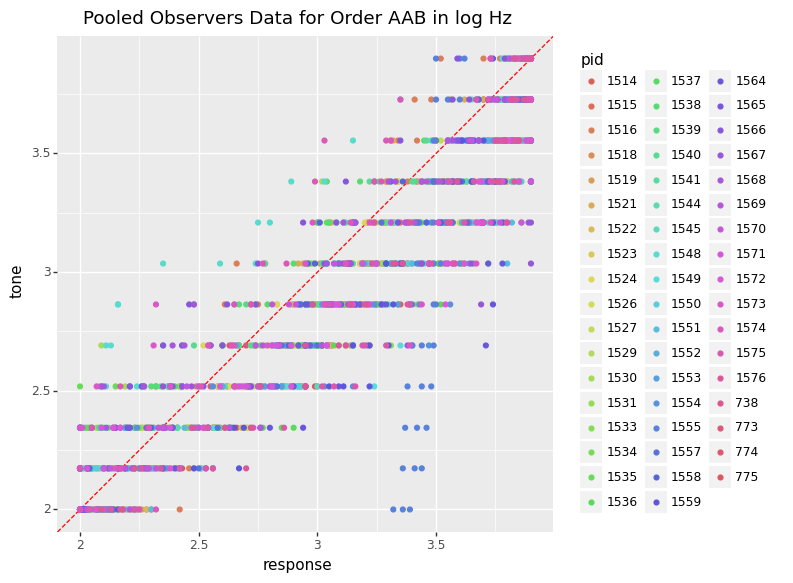

<ggplot: (8785182683625)>

In [ ]:
# plotting all pooled individual data
(
  ggplot(block_df, 
           aes(x='response', y='tone', color="pid"))
  + geom_abline(aes(intercept=0, slope=1), color='red', linetype='dashed') # identity line
  + geom_point()
  + coord_equal()
  + pn.labels.ggtitle("Pooled Observers Data for Order AAB in log Hz")
)

In [ ]:
# plotting individual data by participants
(
  ggplot(block_df, 
           aes(x='response', y='tone'))
  + geom_abline(aes(intercept=0, slope=1), color='red', linetype='dashed') # identity line
  + geom_point(aes(color='block'))
  + coord_equal()
  + facet_grid('. ~ pid')
  + pn.labels.ggtitle("Split Observer Data for Order AAB in Log Hz")
)

TypeError: ignored

In [ ]:
# getting differences across blocks 
def compare_blocks(grp):
  same_noise = float(grp[grp.block == 'base']['response']) - float(grp[grp.block == 'same']['response'])
  diff_noise = float(grp[grp.block == 'base']['response']) - float(grp[grp.block == 'diff']['response'])
  samediff_noise = float(grp[grp.block == 'same']['response']) - float(grp[grp.block == 'diff']['response'])
  return pd.Series([same_noise, diff_noise, samediff_noise], ['AA (same)', 'A1B (diff)', 'A2B (samediff)'])

In [ ]:
same_vs_diff_df = (
  block_df
  .groupby(['pid', 'tone'], as_index=False)
  .apply(compare_blocks)
  .melt(id_vars=['pid', 'tone'], value_vars=['AA (same)', 'A1B (diff)', 'A2B (samediff)'], 
  var_name='block_cond', value_name='tone_diff')
  )

same_vs_diff_df

,pid,tone,block_cond,tone_diff
0,738,2.000000,AA (same),0.00
1,738,2.173186,AA (same),-0.02
2,738,2.344392,AA (same),0.09
3,738,2.518514,AA (same),-0.61
4,738,2.691081,AA (same),-0.10
...,...,...,...,...
1903,1576,3.208979,A2B (samediff),0.16
1904,1576,3.381837,A2B (samediff),0.17
1905,1576,3.554489,A2B (samediff),0.03
1906,1576,3.727297,A2B (samediff),0.00


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


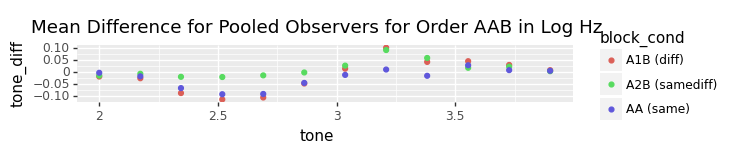

<ggplot: (8785180671017)>

In [ ]:
# plotting mean differences between 2 blocks across all participants 
across_obv_mean = (
    same_vs_diff_df
    .drop("pid", axis=1)
    .groupby(by=["tone", "block_cond"], as_index=False)
    .apply(np.mean)
    )

(
  ggplot(across_obv_mean, 
           aes(x='tone', y='tone_diff', color='block_cond'))
  + geom_point()
  + coord_equal()
  + pn.labels.ggtitle("Mean Difference for Pooled Observers for Order AAB in Log Hz")
) # add error bars at some point 

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


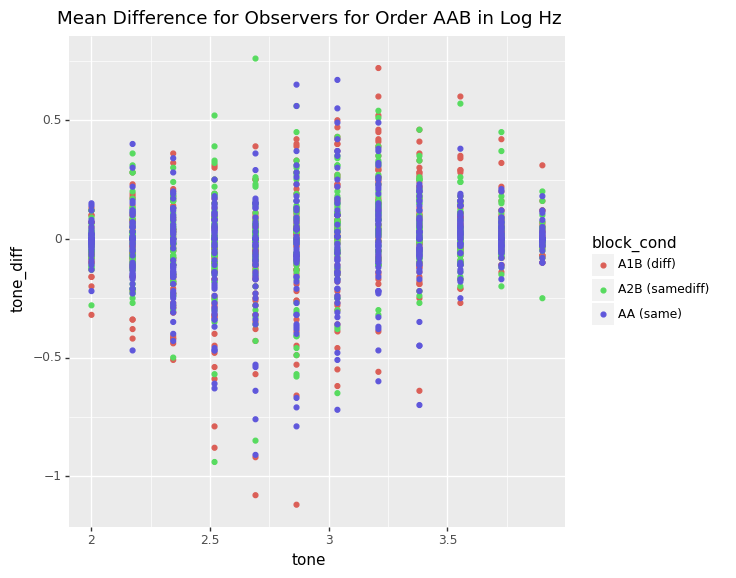

<ggplot: (8785180983397)>

In [ ]:
# show average across tone, show average tone diff per observer
across_tone_mean = (
    same_vs_diff_df
    .groupby(by=["tone", "block_cond", "pid"], as_index=False)
    .apply(np.mean)
    )

(
  ggplot(across_tone_mean, 
           aes(x='tone', y='tone_diff', color='block_cond'))
  + geom_point()
  + coord_equal()
  #+ facet_grid('. ~ pid') # split by participant 
  + pn.labels.ggtitle("Mean Difference for Observers for Order AAB in Log Hz") 
) # add error bars at some point 

In [ ]:
# plotting differences between 2 different blocks by participants 
(
  ggplot(same_vs_diff_df, 
           aes(x='tone', y='tone_diff', color='block_cond'))
  + geom_point()
  + coord_equal()
  + facet_grid('. ~ pid')
  + pn.labels.ggtitle("Mean Difference for Split Observers for Order AAB in Log Hz")
)

TypeError: ignored

In [ ]:
# t-test for differences across all subjects 
same_diff_response = same_vs_diff_df[["block_cond", "tone_diff"]] # extract only block cond and diff columns 
same_res = same_diff_response[same_diff_response["block_cond"] == 'AA (same)'] # isolate "same" cond
diff_res = same_diff_response[same_diff_response["block_cond"] == 'A1B (diff)'] # isolate "diff" cond
samediff_res = same_diff_response[same_diff_response["block_cond"] == 'A2B (samediff)']
t, p = stats.ttest_rel(same_res["tone_diff"], diff_res["tone_diff"])
t1, p1 = stats.ttest_rel(same_res["tone_diff"], samediff_res["tone_diff"])
t2, p2 = stats.ttest_rel(diff_res["tone_diff"], samediff_res["tone_diff"])

print('AA (same) paired t-test t and p values', t, p)
print('A1B (diff) paired t-test t and p values', t1, p2)
print('A2B (samediff) paired t-test t and p values', t2, p2)

AA (same) paired t-test t and p values -1.6980093212562675 0.0899959232265112
A1B (diff) paired t-test t and p values -3.2327667259200816 0.0005514224988446768
A2B (samediff) paired t-test t and p values -3.4721175682152827 0.0005514224988446768


In [ ]:
# correlation between blocks on tone differences 
x = np.corrcoef(same_res["tone_diff"], diff_res["tone_diff"])
y = np.corrcoef(same_res["tone_diff"], samediff_res["tone_diff"])
z = np.corrcoef(diff_res["tone_diff"], samediff_res["tone_diff"])

print('AA (same) correlation', x) 
print('A1B (diff) correlation', y)
print('A2B (samediff) correlation', z)

AA (same) correlation [[1.         0.64162409]
 [0.64162409 1.        ]]
A1B (diff) correlation [[ 1.         -0.32559616]
 [-0.32559616  1.        ]]
A2B (samediff) correlation [[1.        0.5163132]
 [0.5163132 1.       ]]


In [ ]:
 # correlations between blocks for raw responses (Hz)
tone_response_df = block_df[["block", "response"]] # isolate block value and responses 

base_tres = tone_response_df[tone_response_df["block"] == "base"] # isolate base 
same_tres = tone_response_df[tone_response_df["block"] == "same"] # isolate same
diff_tres = tone_response_df[tone_response_df["block"] == "diff"] # isolate diff 

xt = np.corrcoef(base_tres["response"], same_tres["response"])
xt1 = np.corrcoef(base_tres["response"], diff_tres["response"])
xt2 = np.corrcoef(same_tres["response"], diff_tres["response"])

print("AA (same) response correlation", xt)
print("A1B (diff) response correlation", xt1)
print("A2B (samediff) response correlation", xt2)

AA (same) response correlation [[1.         0.96031305]
 [0.96031305 1.        ]]
A1B (diff) response correlation [[1.         0.95157999]
 [0.95157999 1.        ]]
A2B (samediff) response correlation [[1.         0.96586549]
 [0.96586549 1.        ]]


In [ ]:
# std of differences 
AAstd = statistics.stdev(same_res["tone_diff"])
A1Bstd = statistics.stdev(diff_res["tone_diff"])
A2Bstd = statistics.stdev(samediff_res["tone_diff"])

print('AA (same) STD', AAstd) 
print('A1B (diff) STD', A1Bstd)
print('A2B (samediff) STD', A2Bstd)

AA (same) STD 0.18512285301299505
A1B (diff) STD 0.20438503603610422
A2B (samediff) STD 0.16580198318443254


In [ ]:
# 95% confidence intervals of mean differences
same_vs_diff_df = same_vs_diff_df.astype({"pid": int})

# finding means
AAmean = statistics.mean(same_res["tone_diff"])
A1Bmean = statistics.mean(diff_res["tone_diff"])
A2Bmean = statistics.mean(samediff_res["tone_diff"])

n = len(np.unique(same_vs_diff_df["pid"])) # length
sqrtn = len(np.unique(same_vs_diff_df["pid"]))**0.5 # square root of sample of size n

# calculate CIs
AAlow_ci, AAhigh_ci = AAmean - 1.96 * (AAstd/sqrtn), AAmean + 1.96 * (AAstd/sqrtn)
A1Blow_ci, A1Bhigh_ci = A1Bmean - 1.96 * (A1Bstd/sqrtn), A1Bmean + 1.96 * (A1Bstd/sqrtn)
A2Blow_ci, A2Bhigh_ci = A2Bmean - 1.96 * (A2Bstd/sqrtn), A2Bmean + 1.96 * (A2Bstd/sqrtn)

print("AA (same) mean CIs", AAlow_ci, AAhigh_ci)
print("A1B (diff) mean CIs", A1Blow_ci, A1Bhigh_ci)
print("A2B (samediff) mean CIs", A2Blow_ci, A2Bhigh_ci)

AA (same) mean CIs -0.07532743718337212 0.024352594416076526
A1B (diff) mean CIs -0.06934980924375028 0.04070201050161194
A2B (samediff) mean CIs -0.0334747996589098 0.05580184368406706


In [ ]:
# 95% confidence intervals of std differences

df = n - 1 # find degrees of freedom 

AAlow_stdci, AAhigh_stdci = AAstd*(df/(chi2.ppf(1-0.05, df)))**0.5, AAstd*(df/(chi2.ppf(0.05, df)))**0.5
A1Blow_stdci, A1Bhigh_stdci = A1Bstd*(df/(chi2.ppf(1-0.05, df)))**0.5, A1Bstd*(df/(chi2.ppf(0.05, df)))**0.5
A2Blow_stdci, A2Bhigh_stdci = A2Bstd*(df/(chi2.ppf(1-0.05, df)))**0.5, A2Bstd*(df/(chi2.ppf(0.05, df)))**0.5

print("AA (same) STD CIs", AAlow_stdci, AAhigh_stdci)
print("A1B (diff) STD CIs", A1Blow_stdci, A1Bhigh_stdci)
print("A2B (samediff) STD CIs", A2Blow_stdci, A2Bhigh_stdci)

#upper limit: =SD*SQRT((N-1)/CHISQ.INV(1-(alpha/2), N-1))
#lower limit: =SD*SQRT((N-1)/CHISQ.INV((alpha/2), N-1))

AA (same) STD CIs 0.15974746227952352 0.22115147720698428
A1B (diff) STD CIs 0.17636931531292188 0.24416246780301218
A2B (samediff) STD CIs 0.1430749668317075 0.1980703781748161


# ABA Data

In [ ]:
# import in data from experiment ABA - sample pool of 7
data, meta = df_from_jatos_export("jatos_results_20210624205604.txt")
# ('/content/jatos_results_20210623104111.txt') # sample filepath, to be linked to drive later
data_df = data[data["sender"] == "response"] # select only relevant rows 
print(data_df)

       sender sender_type   sender_id  ... observer_group  debrief  pid
9    response   html.Form   1100101.0  ...   random_first      NaN  943
13   response   html.Form   1100111.0  ...   random_first      NaN  943
17   response   html.Form   1100121.0  ...   random_first      NaN  943
21   response   html.Form   1100131.0  ...   random_first      NaN  943
25   response   html.Form   1100141.0  ...   random_first      NaN  943
..        ...         ...         ...  ...            ...      ...  ...
141  response   html.Form   1102171.0  ...   random_first      NaN  890
145  response   html.Form   1102181.0  ...   random_first      NaN  890
149  response   html.Form   1102191.0  ...   random_first      NaN  890
153  response   html.Form  11021101.0  ...   random_first      NaN  890
157  response   html.Form  11021111.0  ...   random_first      NaN  890

[252 rows x 26 columns]


In [ ]:
# import in data from experiment ABA - mTurk pool of 50
data2, meta3 = df_from_jatos_export("jatos_results_20210701221216.txt")
# ('/content/jatos_results_20210623104111.txt') # sample filepath, to be linked to drive later
data2_df = data2[data2["sender"] == "response"] # select only relevant rows 
print(data2_df)

       sender sender_type   sender_id  ... pitch  debrief   pid
9    response   html.Form   1100101.0  ...   NaN      NaN  1510
13   response   html.Form   1100111.0  ...   NaN      NaN  1510
17   response   html.Form   1100121.0  ...   NaN      NaN  1510
21   response   html.Form   1100131.0  ...   NaN      NaN  1510
25   response   html.Form   1100141.0  ...   NaN      NaN  1510
..        ...         ...         ...  ...   ...      ...   ...
141  response   html.Form   1102171.0  ...   NaN      NaN  1441
145  response   html.Form   1102181.0  ...   NaN      NaN  1441
149  response   html.Form   1102191.0  ...   NaN      NaN  1441
153  response   html.Form  11021101.0  ...   NaN      NaN  1441
157  response   html.Form  11021111.0  ...   NaN      NaN  1441

[1944 rows x 30 columns]


In [ ]:
# combining all the data into 1 df - total of 61 participants
datas_df = data_df.append(data2_df)

datas_df = datas_df.astype({"response": int})

# adding data to AAB dict
by_block_2 = {}
def add_to_dict_2(df):
  pid = pd.unique(df['pid'])[0]
  # NOTE this is only valid with this one condition, ie same
  block_cond = {1:'base', 2:'diff', 3:'same'}[int(pd.unique(df['sequence_order'])[0])]
  by_block_2[pid, block_cond] = [np.sort([response_to_hz(x) for x in df['response']]), 
                                 np.sort(df['current_tone'])]

(datas_df
 .groupby(['pid', 'sequence_order'], as_index=False)
 .apply(add_to_dict_2)
)

by_block_2

{('1441',
  'base'): [array([ 100.        ,  144.54397707,  263.02679919,  645.65422903,
          724.43596007,  977.23722096, 2238.72113857, 2884.03150313,
         4570.88189615, 5495.40873858, 7585.77575029, 7762.47116629]), array([ 100.,  149.,  221.,  330.,  491.,  731., 1087., 1618., 2409.,
         3585., 5337., 7943.])],
 ('1441',
  'diff'): [array([ 109.64781961,  117.48975549,  213.79620895,  707.94578438,
          776.24711663,  831.7637711 , 1023.29299228, 3019.9517204 ,
         3090.29543251, 4168.6938347 , 7079.45784384, 7943.28234724]), array([ 100.,  149.,  221.,  330.,  491.,  731., 1087., 1618., 2409.,
         3585., 5337., 7943.])],
 ('1441',
  'same'): [array([ 100.        ,  134.89628826,  154.88166189,  630.95734448,
         1071.51930524, 1698.24365246, 2691.53480393, 3235.9365693 ,
         4073.80277804, 5248.0746025 , 7943.28234724, 7943.28234724]), array([ 100.,  149.,  221.,  330.,  491.,  731., 1087., 1618., 2409.,
         3585., 5337., 7943.])],
 ('1

## Parsing ABA Data

In [ ]:
pids, block_id, real, data = [], [], [], []
for key, (responses, tones) in by_block_2.items():
  pids.extend([key[0]]*len(responses))
  block_id.extend([key[1]]*len(responses))
  data.extend(responses)
  real.extend(tones)
block_df2 = pd.DataFrame({'pid': pids, 'block': block_id, 'tone': real, 'response': data})
block_df2['tone'] = np.log10(block_df2.tone)
block_df2['response'] = np.log10(block_df2.response)
block_df2

,pid,block,tone,response
0,1441,base,2.000000,2.00
1,1441,base,2.173186,2.16
2,1441,base,2.344392,2.42
3,1441,base,2.518514,2.81
4,1441,base,2.691081,2.86
...,...,...,...,...
2191,943,same,3.208979,3.41
2192,943,same,3.381837,3.44
2193,943,same,3.554489,3.69
2194,943,same,3.727297,3.72


## Exploratory Analysis of ABA Data

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


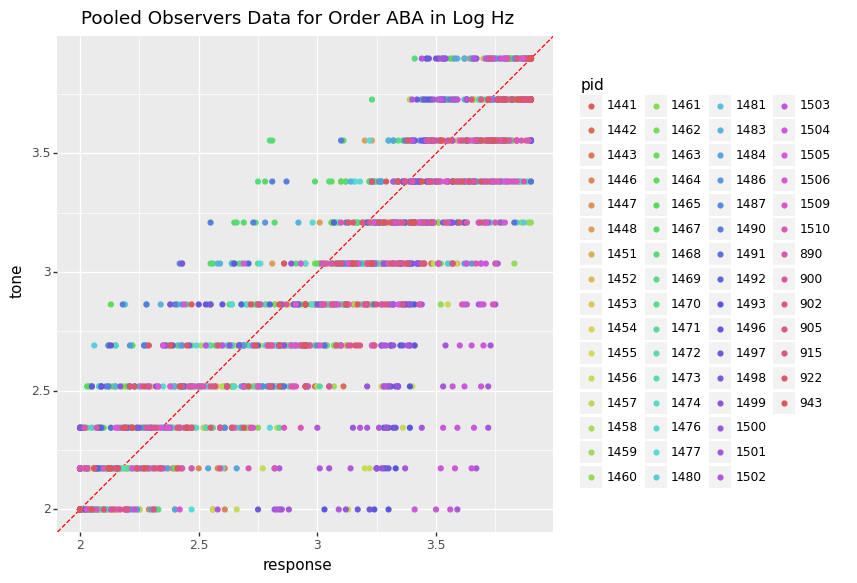

<ggplot: (8785169357293)>

In [ ]:
# plotting all pooled individual data
(
  ggplot(block_df2, 
           aes(x='response', y='tone', color="pid"))
  + geom_abline(aes(intercept=0, slope=1), color='red', linetype='dashed') # identity line
  + geom_point()
  + coord_equal()
  + pn.labels.ggtitle("Pooled Observers Data for Order ABA in Log Hz")
)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


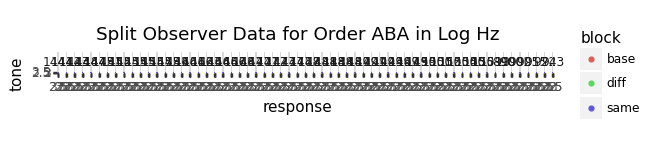

<ggplot: (8785169346549)>

In [ ]:
# plotting individual data by participants
(
  ggplot(block_df2, 
           aes(x='response', y='tone'))
  + geom_abline(aes(intercept=0, slope=1), color='red', linetype='dashed') # identity line
  + geom_point(aes(color='block'))
  + coord_equal()
  + facet_grid('. ~ pid')
  + pn.labels.ggtitle("Split Observer Data for Order ABA in Log Hz")
)

In [ ]:
# getting differences across blocks 

same_vs_diff_df2 = (
  block_df2
  .groupby(['pid', 'tone'], as_index=False)
  .apply(compare_blocks)
  .melt(id_vars=['pid', 'tone'], value_vars=['AA (same)', 'A1B (diff)', 'A2B (samediff)'], 
  var_name='block_cond', value_name='tone_diff')
  )

same_vs_diff_df2

,pid,tone,block_cond,tone_diff
0,1441,2.000000,AA (same),0.00
1,1441,2.173186,AA (same),0.03
2,1441,2.344392,AA (same),0.23
3,1441,2.518514,AA (same),0.01
4,1441,2.691081,AA (same),-0.17
...,...,...,...,...
2191,943,3.208979,A2B (samediff),0.13
2192,943,3.381837,A2B (samediff),0.15
2193,943,3.554489,A2B (samediff),0.17
2194,943,3.727297,A2B (samediff),-0.13


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


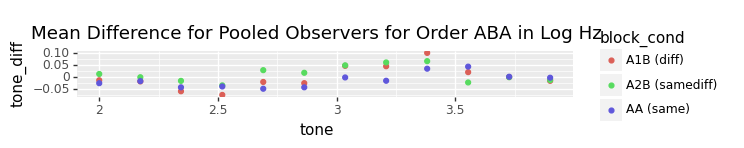

<ggplot: (8785180665257)>

In [ ]:
# plotting mean differences between 2 blocks across all participants 
across_obv_mean2 = (
    same_vs_diff_df2
    .drop("pid", axis=1)
    .groupby(by=["tone", "block_cond"], as_index=False)
    .apply(np.mean)
    )

(
  ggplot(across_obv_mean2, 
           aes(x='tone', y='tone_diff', color='block_cond'))
  + geom_point()
  + coord_equal()
  + pn.labels.ggtitle("Mean Difference for Pooled Observers for Order ABA in Log Hz")
) # add error bars at some point 

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


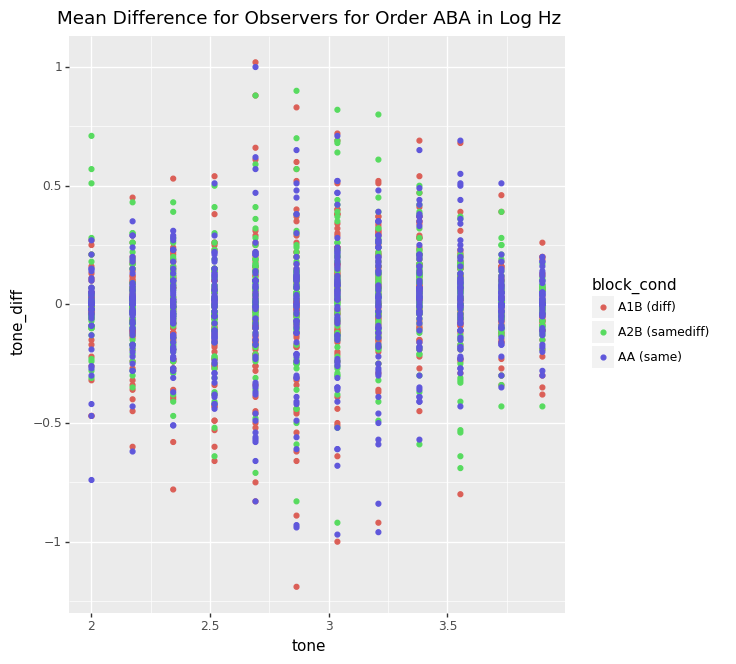

<ggplot: (8785168043797)>

In [ ]:
# show average across tone, show average tone diff per observer
across_tone_mean2 = (
    same_vs_diff_df2
    .groupby(by=["tone", "block_cond", "pid"], as_index=False)
    .apply(np.mean)
    )

(
  ggplot(across_tone_mean2, 
           aes(x='tone', y='tone_diff', color='block_cond'))
  + geom_point()
  + coord_equal()
  #+ facet_grid('. ~ pid') # split by participant 
  + pn.labels.ggtitle("Mean Difference for Observers for Order ABA in Log Hz") 
) # add error bars at some point 

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


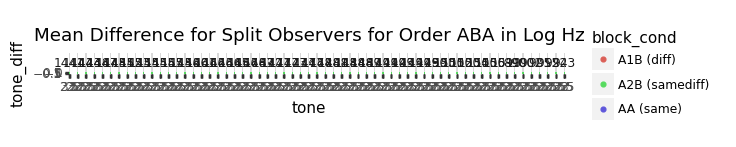

<ggplot: (8785167787977)>

In [ ]:
# plotting differences between 2 different blocks by participants 
(
  ggplot(same_vs_diff_df2, 
           aes(x='tone', y='tone_diff', color='block_cond'))
  + geom_point()
  + coord_equal()
  + facet_grid(". ~ pid")
  + pn.labels.ggtitle("Mean Difference for Split Observers for Order ABA in Log Hz")
)

In [ ]:
# t-test for differences across all subjects 
same_diff_response2 = same_vs_diff_df2[["block_cond", "tone_diff"]] # extract only block cond and diff columns 
same_res2 = same_diff_response2[same_diff_response2["block_cond"] == 'AA (same)'] # isolate "same" cond
diff_res2 = same_diff_response2[same_diff_response2["block_cond"] == 'A1B (diff)'] # isolate "diff" cond
samediff_res2 = same_diff_response2[same_diff_response2["block_cond"] == 'A2B (samediff)']
t3, p3 = stats.ttest_rel(same_res2["tone_diff"], diff_res2["tone_diff"])
t4, p4 = stats.ttest_rel(same_res2["tone_diff"], samediff_res2["tone_diff"])
t5, p5 = stats.ttest_rel(diff_res2["tone_diff"], samediff_res2["tone_diff"])

print('AA (same) paired t-test t and p values', t3, p3)
print('A1B (diff) paired t-test t and p values', t4, p4)
print('A2B (samediff) paired t-test t and p values', t5, p5)

AA (same) paired t-test t and p values -1.589958904557593 0.11227643109622293
A1B (diff) paired t-test t and p values -1.8973857699964372 0.05817085364945201
A2B (samediff) paired t-test t and p values -1.6247229765141435 0.10465265631655778


In [ ]:
# correlation between blocks on tone differences  
x1 = np.corrcoef(same_res2["tone_diff"], diff_res2["tone_diff"])
y1 = np.corrcoef(same_res2["tone_diff"], samediff_res2["tone_diff"])
z1 = np.corrcoef(diff_res2["tone_diff"], samediff_res2["tone_diff"])

print('AA (same) correlation', x1) 
print('A1B (diff) correlation', y1)
print('A2B (samediff) correlation', z1)

AA (same) correlation [[1.         0.60094717]
 [0.60094717 1.        ]]
A1B (diff) correlation [[ 1.         -0.43532981]
 [-0.43532981  1.        ]]
A2B (samediff) correlation [[1.        0.4579663]
 [0.4579663 1.       ]]


In [ ]:
 # correlations between blocks for raw responses (Hz)
block_df2 = block_df2[["block", "response"]] # isolate block value and responses 

base_tres2 = block_df2[block_df2["block"] == "base"] # isolate base 
same_tres2 = block_df2[block_df2["block"] == "same"] # isolate same
diff_tres2 = block_df2[block_df2["block"] == "diff"] # isolate diff 

xt3 = np.corrcoef(base_tres2["response"], same_tres2["response"])
xt4 = np.corrcoef(base_tres2["response"], diff_tres2["response"])
xt5 = np.corrcoef(same_tres2["response"], diff_tres2["response"])

print("AA (same) response correlation", xt3)
print("A1B (diff) response correlation", xt4)
print("A2B (samediff) response correlation", xt5)

AA (same) response correlation [[1.         0.93477771]
 [0.93477771 1.        ]]
A1B (diff) response correlation [[1.         0.93179724]
 [0.93179724 1.        ]]
A2B (samediff) response correlation [[1.         0.94532075]
 [0.94532075 1.        ]]


In [ ]:
# std 
AA_std = statistics.stdev(same_res2["tone_diff"])
A1B_std = statistics.stdev(diff_res2["tone_diff"])
A2B_std = statistics.stdev(samediff_res2["tone_diff"])

print('AA (same) STD', AA_std) 
print('A1B (diff) STD', A1B_std)
print('A2B (samediff) STD', A2B_std)

AA (same) STD 0.22726398911032727
A1B (diff) STD 0.2301532017776175
A2B (samediff) STD 0.2043371986868646


In [ ]:
# confidence intervals at 95% 
same_vs_diff_df2 = same_vs_diff_df2.astype({"pid": int})

# finding means
AA_mean = statistics.mean(same_res2["tone_diff"])
A1B_mean = statistics.mean(diff_res2["tone_diff"])
A2B_mean = statistics.mean(samediff_res2["tone_diff"])

sqrt_n = len(np.unique(same_vs_diff_df2["pid"]))**0.5 # square root of sample of size n

# calculate CIs
AA_low_ci, AA_high_ci = AA_mean - 1.96 * (AA_std/sqrt_n), AA_mean + 1.96 * (AA_std/sqrt_n)
A1B_low_ci, A1B_high_ci = A1B_mean - 1.96 * (A1B_std/sqrt_n), A1B_mean + 1.96 * (A1B_std/sqrt_n)
A2B_low_ci, A2B_high_ci = A2B_mean - 1.96 * (A2B_std/sqrt_n), A2B_mean + 1.96 * (A2B_std/sqrt_n)

print("AA (same) CIs", AA_low_ci, AA_high_ci)
print("A1B (diff) CIs", A1B_low_ci, A1B_high_ci)
print("A2B (samediff) CIs", A2B_low_ci, A2B_high_ci)

AA (same) CIs -0.07067995827371486 0.043384876306501764
A1B (diff) CIs -0.059396816072152976 0.05611812754756281
A2B (samediff) CIs -0.039270690131913547 0.06328708357453647


In [ ]:
# 95% confidence intervals of std differences

DF = n - 1 # find degrees of freedom 

AAlow_std_ci, AAhigh_std_ci = AA_std*(df/(chi2.ppf(1-0.05, DF)))**0.5, AA_std*(DF/(chi2.ppf(0.05, DF)))**0.5
A1Blow_std_ci, A1Bhigh_std_ci = A1B_std*(df/(chi2.ppf(1-0.05, DF)))**0.5, A1B_std*(DF/(chi2.ppf(0.05, DF)))**0.5
A2Blow_std_ci, A2Bhigh_std_ci = A2B_std*(df/(chi2.ppf(1-0.05, DF)))**0.5, A2B_std*(DF/(chi2.ppf(0.05, DF)))**0.5

print("AA (same) STD CIs", AAlow_std_ci, AAhigh_std_ci)
print("A1B (diff) STD CIs", A1Blow_std_ci, A1Bhigh_std_ci)
print("A2B (samediff) STD CIs", A2Blow_std_ci, A2Bhigh_std_ci)

#upper limit: =SD*SQRT((N-1)/CHISQ.INV(1-(alpha/2), N-1))
#lower limit: =SD*SQRT((N-1)/CHISQ.INV((alpha/2), N-1))

AA (same) STD CIs 0.19611217597941602 0.27149412452158345
A1B (diff) STD CIs 0.1986053548823636 0.27494563598511684
A2B (samediff) STD CIs 0.17632803518451615 0.24410532034510612


# BAA Data